In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv
/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv
/kaggle/input/llm-detect-ai-generated-text/test_essays.csv
/kaggle/input/llm-detect-ai-generated-text/train_essays.csv


# Problem Description

Recently large language models (LLMs) have become advanced and models like ChatGPT are able of generating text that is challenging to distinguish from that written by humans. The goal of this problem is to create transparency and encourage research on AI detection by looking at the real world and detecting AI techniques in environments like primary and secondary schools. It is increasingly prevalent that we see scenarios arise such that student assignments like school essays may contain paragraphs or even entire essays written entirely by AI instead of students themselves. Let's help to prevent plagiarism, while continuing to foster creativity and new types of learning using AI. The data has texts of moderate length and our goal again is to identify LLM artifacts and detect which texts are written by LLMs.

# Data Description

We have datasets with essays that are written by a combination of middle and high schools students, and some written using a large language model (LLM). These datasets are sourced from Kaggle at https://www.kaggle.com/competitions/llm-detect-ai-generated-text/data and the competition dataset comprises about 10,000 essays. The main dataset train_essays.csv is about 4.4 MB with 1378 rows and 4 columns, one of which contains the 'generated' feature that indicates 1 for essays written by LLMs and 0 for those written by humans. The other main feture is the 'text' column which is a fairly long amount of string text that we need to analyze and process for our analysis.

## Imports

In [2]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.model_selection import train_test_split


from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    trainers,
    Tokenizer,
)

from transformers import PreTrainedTokenizerFast

import gc
import nltk
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.metrics import AUC
from keras.callbacks import EarlyStopping
from keras.models import load_model



# Load data

In [3]:
train = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_essays.csv')
test = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/test_essays.csv')
prompts = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/train_prompts.csv')
submission = pd.read_csv('/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv')

# Exploratory Data Analysis (EDA)

In [4]:
train.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [5]:
prompts.head()

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


In [6]:
train['text'][0].count('\n')

6

In [7]:
train['text'] = train['text'].str.replace('\n', ' ')
test['text'] = test['text'].str.replace('\n', ' ')

In [8]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [9]:
train.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [10]:

print("Generated By LLM :",train[train['generated']==1].shape[0])
print("Written by a Student :",train[train['generated']==0].shape[0])


Generated By LLM : 3
Written by a Student : 1375


In [11]:
written_human=train[train['generated']==0]
written_LLM=train[train['generated']==1]

<Axes: >

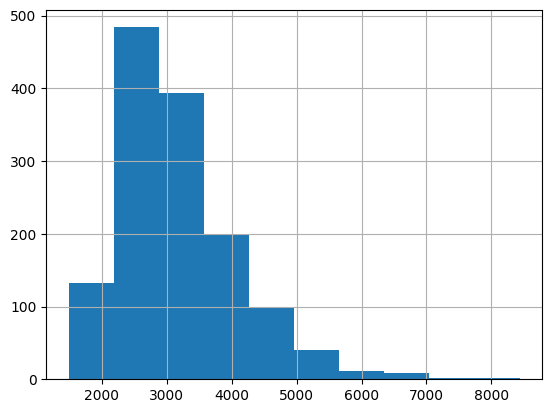

In [12]:
# Human
written_human['text'].str.len().hist() #string length


<Axes: >

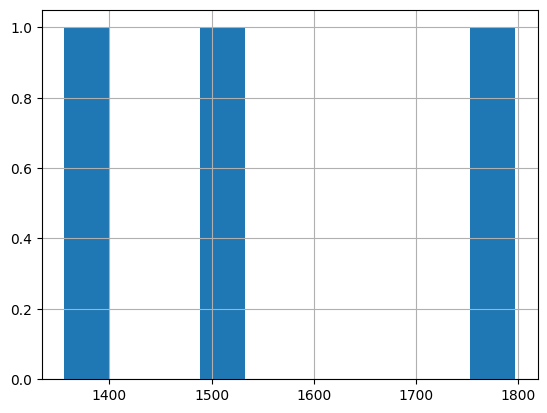

In [13]:
written_LLM['text'].str.len().hist() #string length

Here, we can see that LLMs wrote string length between approximately 1400 and 1800 whereas humans wrote string length essays between 1500 to about 7000.

Humans' essays have more range of string length and the histogram decreases smoothly from 3000 to 7000 whereas the limited sample size of 3 for LLMs shows us that all samples were below a length of 2000 and seem randomized in length.

<Axes: >

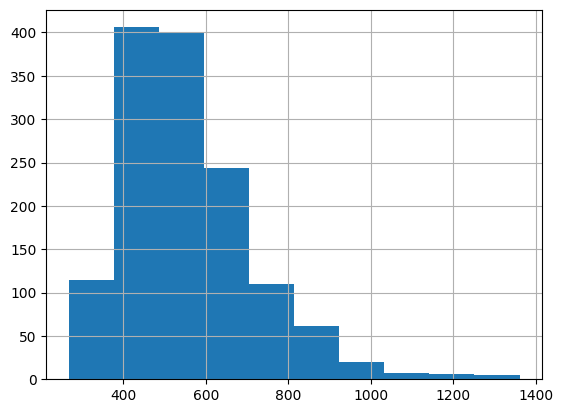

In [14]:
written_human['text'].str.split().map(lambda x: len(x)).hist()#number of words

<Axes: >

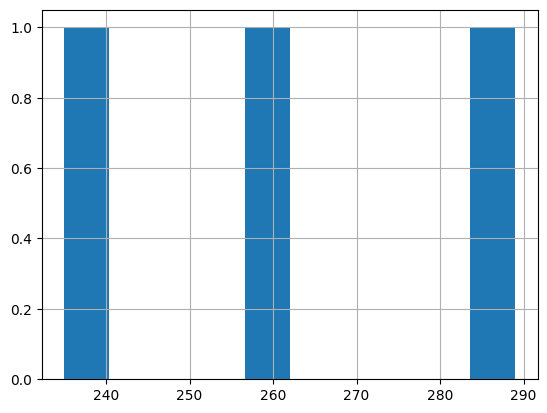

In [15]:
written_LLM['text'].str.split().map(lambda x: len(x)).hist()#number of words

The number of words that humans write is from 100 to 1200+ whereas from LLM it's from 240 to 280. We can see that human generated essays are longer compared to those generated by LLMs.

In [16]:
stop=set(nltk.corpus.stopwords.words('english'))

corpus_h=[]
new1= written_human['text'].str.split()
new1=new1.values.tolist()
corpus_h=[word for i in new1 for word in i]

dict_h={}
for word in corpus_h:
    if word in stop:
        if word not in dict_h.keys():
            dict_h[word]=1
        else :
            dict_h[word]+=1
            

# same for LLM
corpus_LLM=[]
new2= written_LLM['text'].str.split()
new2=new2.values.tolist()
corpus_LLM=[word for i in new2 for word in i]

dict_LLM={}
for word in corpus_LLM:
    if word in stop:
        if word not in dict_LLM.keys():
            dict_LLM[word]=1
        else :
            dict_LLM[word]+=1

<BarContainer object of 15 artists>

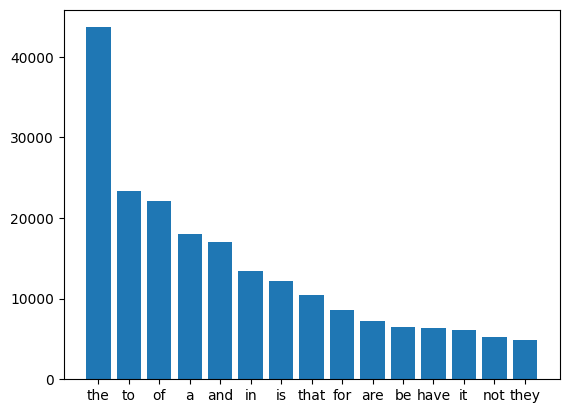

In [17]:
top_15=sorted(dict_h.items(), key=lambda x:x[1],reverse=True)[:15] 
x,y=zip(*top_15)
plt.bar(x,y)

<BarContainer object of 15 artists>

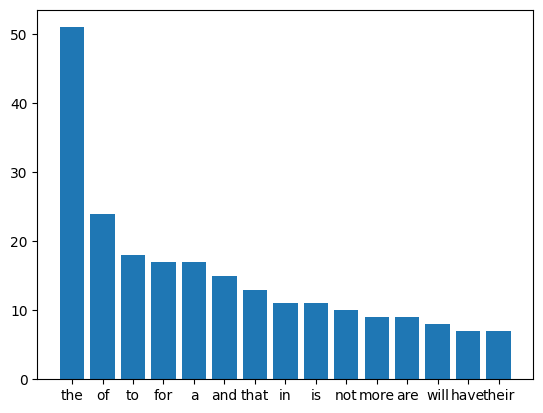

In [18]:
# same type of plot for LLM
top_15=sorted(dict_LLM.items(), key=lambda x:x[1],reverse=True)[:15] 
x,y=zip(*top_15)
plt.bar(x,y)

We can see that both humans and LLMs use about the same amount of stop words.

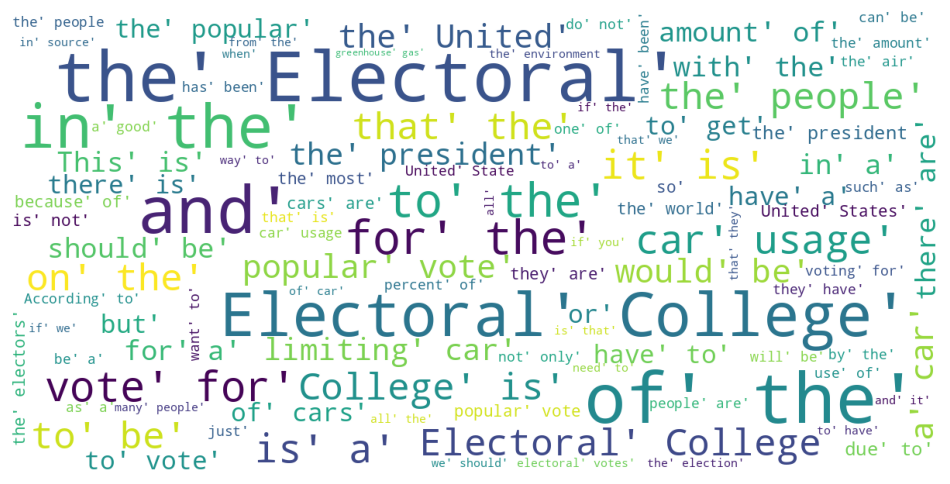

In [19]:

def create_wordcloud(data):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stop,
        max_words=100,
        max_font_size=30,
        scale=3,
        random_state=1)

    wordcloud=wordcloud.generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')

    plt.imshow(wordcloud)
    plt.show()

create_wordcloud(corpus_h)



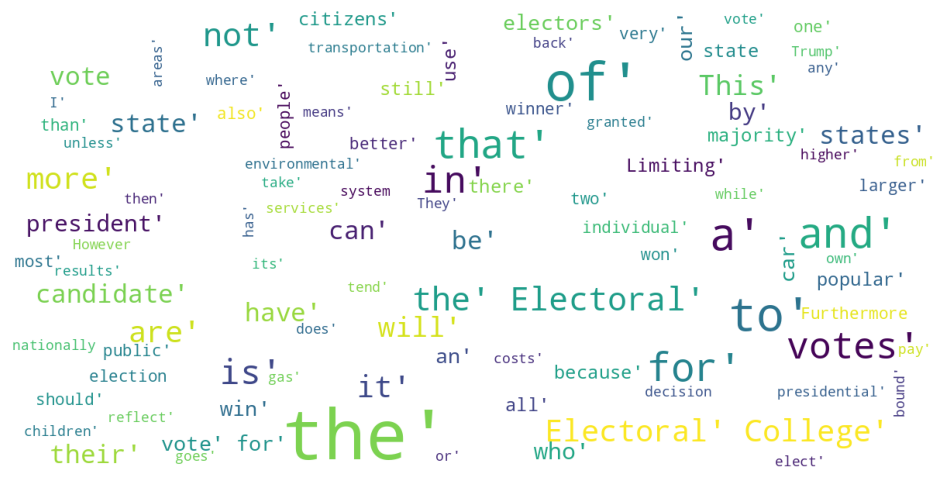

In [20]:
create_wordcloud(corpus_LLM)

We can see that the human body of texts uses more words like Electoral College and has denser output compared to the LLM body of text. A large part of this is also because there are only three LLM samples where there are thousands of human essays in the provided training dataset, so there is a heavy mismatch in terms of provided input.

# Preprocessing

In [21]:
train_df, val_df = train_test_split(train, test_size=0.2, random_state=8, stratify=train['generated'])

## Create Tokenizers
In this section, I train tokenizers from scratch by leveraging Hugging Face’s tokenizers package. Here I use the BPE algorithm, Byte Pair Encoding, which uses the frequency of subword patterns in order to create a shorter list for merging. It is able to generate unambiguous tokens.

In [22]:
tk = Tokenizer(models.BPE(unk_token="[UNK]"))
tk.pre_tokenizer = pre_tokenizers.ByteLevel()
tk.normalizer = normalizers.Sequence([normalizers.NFD(), normalizers.Lowercase(),
                                             normalizers.StripAccents()])

trainer = trainers.BpeTrainer(vocab_size=30522, special_tokens=
                              ["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])

data_for_tokenizer_train = train_df['text'].tolist()
tk.train_from_iterator(data_for_tokenizer_train, trainer)

tokenizer = PreTrainedTokenizerFast(
    tokenizer_object=tk,
    sep_token="[SEP]",
    pad_token="[PAD]",
    mask_token="[MASK]",
    unk_token="[UNK]",
    cls_token="[CLS]",
)

train_df['text'] = train_df['text'].apply(
    lambda x: tokenizer.tokenize(x, add_special_tokens=True))

val_df['text'] = val_df['text'].apply(
    lambda x: tokenizer.tokenize(x, add_special_tokens=True))


test['text'] = test['text'].apply(
    lambda x: tokenizer.tokenize(x, add_special_tokens=True))

In [23]:
train

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0
...,...,...,...,...
1373,fe6ff9a5,1,There has been a fuss about the Elector Colleg...,0
1374,ff669174,0,Limiting car usage has many advantages. Such a...,0
1375,ffa247e0,0,There's a new trend that has been developing f...,0
1376,ffc237e9,0,As we all know cars are a big part of our soci...,0


In [24]:
test

,id,prompt_id,text
0,0000aaaa,2,"[Ġa, aa, Ġb, b, b, Ġc, cc, .]"
1,1111bbbb,3,"[Ġb, b, b, Ġc, cc, Ġd, dd, .]"
2,2222cccc,4,"[Ġc, cc, Ġd, dd, Ġe, ee, .]"


# Preprocessing with a TF-IDF Vectorizer

The below textReturn function is for the tokenizer parameter in TfidfVectorizer. It returns the text as is since we already tokenized it.

In [25]:
def textReturn(text):
    return text

vect = TfidfVectorizer(ngram_range=(3, 5), tokenizer=textReturn, preprocessor=textReturn,
                    sublinear_tf=True, token_pattern=None, lowercase=False,
                    min_df=0.001)
vect.fit(train_df['text'])
vocab = vect.vocabulary_
vect = TfidfVectorizer(ngram_range=(3, 5), tokenizer=textReturn, preprocessor=textReturn,
                    sublinear_tf=True, token_pattern=None, lowercase=False,
                    vocabulary=vocab)
X_train = vect.fit_transform(train_df['text']).astype('float32')
X_val = vect.fit_transform(val_df['text']).astype('float32')
X_test = vect.fit_transform(test['text']).astype('float32')

# Model Building

I build a sequential neural network model that uses seven layers, with four dense layers and three dropout layers. I use binary cross entropy loss, with the 'adam' type optimizer, and compute using area under the curve (AUC) as a metric, along with accuracy. I run ten epochs to fit my neural network to the train dataset and I also provide early stopping from the keras library to prevent overfitting.

In [26]:
model = Sequential([
    Input(shape=(X_train.shape[1],), sparse=True),
    Dense(32, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.2),
    Dense(64, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(32, activation='relu', kernel_initializer='he_normal'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                4417760   
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 3

In [27]:
y_train = train_df['generated'].values
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

nn = model.fit(X_train, y_train, batch_size=128, epochs=10, callbacks=[early_stopping])

preds = model.predict(X_val)
print(len(preds))

Epoch 1/10
9/9 [==============================] - 2s 77ms/step - loss: 0.6575 - accuracy: 0.9229 - auc: 0.4873
Epoch 2/10
9/9 [==============================] - 1s 65ms/step - loss: 0.4800 - accuracy: 0.9982 - auc: 0.5889
Epoch 3/10
9/9 [==============================] - 1s 66ms/step - loss: 0.2368 - accuracy: 0.9982 - auc: 0.8105
Epoch 4/10
9/9 [==============================] - 1s 62ms/step - loss: 0.0736 - accuracy: 0.9982 - auc: 0.9745
Epoch 5/10
9/9 [==============================] - 1s 60ms/step - loss: 0.0216 - accuracy: 0.9982 - auc: 0.9823
Epoch 6/10
9/9 [==============================] - 1s 62ms/step - loss: 0.0100 - accuracy: 0.9982 - auc: 1.0000
Epoch 7/10
9/9 [==============================] - 1s 64ms/step - loss: 0.0054 - accuracy: 0.9982 - auc: 1.0000
Epoch 8/10
9/9 [==============================] - 1s 61ms/step - loss: 0.0046 - accuracy: 0.9982 - auc: 1.0000
Epoch 9/10
9/9 [==============================] - 1s 57ms/step - loss: 0.0038 - accuracy: 0.9982 - auc: 1.0000
E

# Results and Analysis

In [28]:
y_val = val_df['generated'].values
auc_score = roc_auc_score(y_val, preds)
print(auc_score)

0.9963636363636363


In [29]:
preds = model.predict(X_test)
print(preds)

1/1 [==============================] - 0s 9ms/step
[[0.19012092]
 [0.19012092]
 [0.19012092]]


In [30]:
submission['generated'] = preds

In [31]:
submission

,id,generated
0,0000aaaa,0.190121
1,1111bbbb,0.190121
2,2222cccc,0.190121


In [32]:
submission.to_csv('submission.csv', index=False)

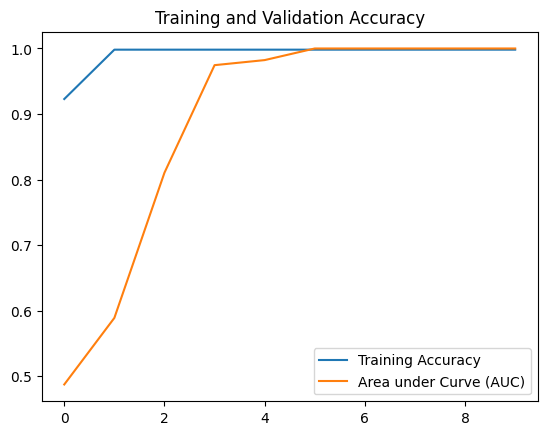

In [33]:
plt.plot(nn.history['accuracy'], label='Training Accuracy')
plt.plot(nn.history['auc'], label='Area under Curve (AUC)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()



The first few times running the model, the training accuracy and AUC quickly increase to close to 1, which is great performance. At later times I've rerun my notebook, the performance is extremely high and already close to 1 at the start, and my guess is that Kaggle might persist some of the model data between runs. With this being said, I am extremely satisfied with the output of the model performance because this means that with the training and validation datasets, the neural net model was able to distinguish well between human and LLM written essays.

# Conclusion

I learned about useful word tokenizers are for analyzing text data and one takeaway I found is how effective some open-source provided encoding libraries are such as Hugging Face’s tokenizers package. Here I use the BPE algorithm, Byte Pair Encoding, which uses the frequency of subword patterns in order to create a shorter list for merging. It is able to generate unambiguous tokens. 

I think that sometimes tokenizers may or may not work well depending on the language set, and the type of algorithm you use. In this case, Hugging Face provides a quick prototyping library for tokenization.

I think that some ways to improve this further could be including more LLM datasets and in the future adding some additional algorithms to discover patterns in the new LLM datasets. However, this type of model would also need to be retrained pretty frequently, considering how quickly LLM models like ChatGPT are improving. It is fascinating that we are able to have some probabilistic determination in applying detection to AI algorithms in English writing, which is useful for real life applications such as education!